# "Into the INFERNO: parameter estimation under uncertainty - Part 5"
> "In this series of posts, we'll be looking at one of the most common problems in high-energy physics; that of estimating some parameter of interest. In this concluding post we'll examine one of the concerns raised in the last post about having to know the analytical effect of nuisance parameters on input features and see how we can instead approximate the effects."

- toc: true
- branch: master
- badges: true
- comments: true
- categories: [statistics, HEP, INFERNO]
- image: images/copied_from_nb/imgs/inferno/approx_inferno_systs.png
- hide: false
- search_exclude: false

![binning comparison](imgs/inferno/approx_inferno_systs.png)

Welcome back to the concluding part of this blog-post series. In case you missed the previous posts: [first](https://gilesstrong.github.io/website/statistics/hep/inferno/2020/12/04/inferno-1.html), [second](https://gilesstrong.github.io/website/statistics/hep/inferno/2020/12/11/inferno-2.html), [third](https://gilesstrong.github.io/website/statistics/hep/inferno/2020/12/18/inferno-3.html), and  [fourth](https://gilesstrong.github.io/website/statistics/hep/inferno/2020/12/31/inferno-4.html).

Last time we applied INFERNO to the toy-example presented in the [INFERNO](https://www.sciencedirect.com/science/article/pii/S0010465519301948) paper, and demonstrated how the method made our parameter estimation more resilient to the effects of nuisance parameters that affect both the shapes of input features and the overall normalisation of the classes. Here we'll look at how we can achieve the same effect without having to know the analytical effect of the nuisance parameters on the input features.

As a reminder, we're using a PyTorch implementation of INFERNO which I've put together. The package can be installed using:

!pip install pytorch_inferno==0.0.1

Docs are located [here](https://gilesstrong.github.io/pytorch_inferno/) and the Github repo is [here](https://github.com/GilesStrong/pytorch_inferno). I'm installing v0.0.1 here, since it was what I used when writing this post, but for your own work, you should grab the latest version.

As an additional note, these blog posts are fully runnable as Jupyter notebooks. You can either download them, or click the Google Colab badge at the top to follow along!

## Approximating INFERNO

The approach as presented last time, requires modelling the effect of the shape nuisances on the inputs in an analytical manner. Usually, though, this is difficult. As an example, in high-energy physics, we often have systematic uncertainties like QCD scale, various energy scales, and correction factors for upstream algorithms. These affect a range of features of the data in complex ways. Additionally, their effects are sometimes modelled by changing fundamental parameters in the Monte Carlo simulator used to generate training data. 

Knowing exactly how variations in a given nuisance parameter alter the input features is not normally possible. Indeed, when we have optimised the likelihood in previous posts, we have assumed this and so haven't fully propagated the effects of the parameters through our classifier, instead we generated up/down systematic variations for the model response and interpolated between them and the nominal template (or extrapolated away from them). The trick, then, is to also do this interpolation/extrapolation inside INFERNO.

When performing a HEP analysis with systematic uncertainties, these up/down variation samples are usually generated via modifying the relevant parameters in the simulation, i.e. for an analysis one has a nominal dataset and also datasets for up and down variations for each nuisance parameter separately. The approximation of INFERNO presented here is designed to work directly on such datasets.

One key point is that we will compare nominal and systematic datasets in terms of template shape, rather than on a per data-point level. This means that the systematic datasets don't have to match the nominal dataset event-wise, i.e. we don't need to know how a given event would change if a certain parameter were altered, instead we only need to know the average effect that changing the parameter causes. This certainly simplifies things from both a simulation and implementation point of view.

### Abstract implementation

The interpolation-based INFERNO loss in pytorch_inferno is implemented similar to the exact version, i.e. as a [callback](https://gilesstrong.github.io/pytorch_inferno/callback.html#AbsCallback). Again, there is an [abstract class](https://gilesstrong.github.io/pytorch_inferno/inferno_interp.html#AbsInferno) implementing the basic functionality, and the idea is that users can inherit from it to apply to their specific problems, e.g in our case [PaperInferno](https://gilesstrong.github.io/pytorch_inferno/inferno_interp.html#PaperInferno). Note however that even the "abstract" class is still designed for a Poisson counting problem.

Let's go through the code function by function:
```python
    def __init__(self, n:int, true_mu:float, aug_alpha:bool=False, n_alphas:int=0, n_steps:int=100, lr:float=0.1,
                 float_b:bool=False, alpha_aux:Optional[List[Distribution]]=None, b_aux:Optional[Distribution]=None):
        super().__init__()
        store_attr()
        self.true_b = self.n-self.true_mu
```

The initialisation is similar to the exact version: Asimov count `n`, and the true signal strength `true_mu`. The true background count is then computed automatically. `n_alphas` is the number of shape systematics to expect and `float_b` is whether or not the background normalisation should be allowed to vary. Any auxiliary measurements for the shape parameters and background yield can be passed as PyTorch distributions to the `alpha_aux` and `b_aux` arguments.

There is also the option to augment the nuisance parameters `aug_alpha`. This is an idea I had which is still experimental - basically the nuisances start each minibatch at random points about their nominal values and undergo Newtonian optimisation according to `lr` and `n_steps`. This could perhaps be thought of as a form of regularisation or data-augmentation. In this example it seems to work well, but as I say, it's still experimental, so I won't talk about it much here.

```python
def on_train_begin(self) -> None:
    self.wrapper.loss_func = None
    for c in self.wrapper.cbs:
        if hasattr(c, 'loss_is_meaned'): c.loss_is_meaned = False
```

Unlike the exact version, when the training starts we don't need to cache a tensor of the nuisance parameters, but we do still want to ensure that the model doesn't have any other losses.

Having passed the nominal input data through the network, we call:
```python
def on_forwards_end(self) -> None:
    r'''Compute loss and replace wrapper loss value'''
    b = self.wrapper.y.squeeze() == 0
    f_s = self.to_shape(self.wrapper.y_pred[~b])
    f_b = self.to_shape(self.wrapper.y_pred[b])
    f_b_up,f_b_dw = self._get_up_down(self.wrapper.x[b])
    self.wrapper.loss_val = self.get_ikk(f_s=f_s, f_b_nom=f_b, f_b_up=f_b_up, f_b_dw=f_b_dw)
```

This extracts the normalised shapes for signal and background (their PDFs) from the network predictions (`self.wrapper.y_pred`). Unlike the exact version, the background predictions don't include the shape nuisances. In order to evaluate these, we pass the background data to `self._get_up_down`, which passes up/down systematic data through the network and returns the shape templates. Currently it an abstract function to be overridden in a problem-specific class. 

```python
@abstractmethod
def _get_up_down(self, x:Tensor) -> Tuple[Tensor,Tensor]:
    r'''Compute up/down shapes. Override this for specific problem.'''
    pass
```

Now that we have nominal shape templates for signal and background, and the shape templates for background after +1 and -1 sigma variations of each shape-affecting nuisance parameters, we are now at a similar state to when we are evaluating the trained models on the benchmark problems in the previous posts. I.e. we can compute the negative log-likelihood, and optimise it by varying the nuisance parameters based on interpolating between the nominal and ±1-sigma variations, for fixed values of the parameter of interest.

The key point is that we actually start with the nuisances at their nominal values, and we only need to evaluate the parameter of interest at its nominal value, so no optimisation is required. The actual implementation includes code for applying the data augmentation mentioned earlier, but I'll remove it here for simplicity.

```python
def get_ikk(self, f_s:Tensor, f_b_nom:Tensor, f_b_up:Tensor, f_b_dw:Tensor) -> Tensor:
    r'''Compute full hessian at true param values, or at random starting values with Newton updates'''
    alpha = torch.zeros((self.n_alphas+1+self.float_b), requires_grad=True, device=self.wrapper.device)
    with torch.no_grad(): alpha[0] += self.true_mu
    get_nll = partialler(calc_nll, s_true=self.true_mu, b_true=self.true_b,
                         f_s=f_s, f_b_nom=f_b_nom, f_b_up=f_b_up, f_b_dw=f_b_dw, alpha_aux=self.alpha_aux, b_aux=self.b_aux)
    nll = get_nll(s_exp=alpha[0], b_exp=self.true_b+alpha[1] if self.float_b else self.true_b, alpha=alpha[1+self.float_b:])
    _,h = calc_grad_hesse(nll, alpha, create_graph=True)
    return torch.inverse(h)[0,0]
```

So, first we create a tensor, `alpha`, to contain the parameter of interest and the nuisance parameters (all zero except the parameter of interest (PoI)), and then we compute the NLL using [calc_nll](https://gilesstrong.github.io/pytorch_inferno/inference.html#calc_nll) (we've called this function in the past when evaluating benchmarks, but it has been wrapped by [calc_profile](https://gilesstrong.github.io/pytorch_inferno/inference.html#calc_profile) to handle multiple PoIs). Once we have the NLL, we can then compute the INFERNO loss as usual by inverting the Hessian of the NLL w.r.t. the PoI and nuisances ([calc_grad_hesse](https://gilesstrong.github.io/pytorch_inferno/inference.html#calc_grad_hesse)), and returning the element corresponding to the PoI.

### Problem-specific class

Similar to last time, we want to inherit from our abstract implementation of INFERNO to better suit the problem at hand. [PaperInferno](https://gilesstrong.github.io/pytorch_inferno/inferno_interp.html#PaperInferno) is included to work with the toy problem in the original paper. I mentioned at the start that this approximation of INFERNO was designed to work with pre-produced datasets that contain both nominal and systematic datasets, however for this example, we'll generate the systematic datasets on the fly since we can analytically modify the inputs. If we were to do this properly, we would generate the systematic datasets beforehand, and allow the callback to sample batches from them during training. Probably I'll eventually add a class to the library that can do this.

Anyway, for now, our class overrides `_get_up_down` like this:

```python   
def _get_up_down(self, x:Tensor) -> Tuple[Tensor,Tensor]:
    if self.r_mods is None and self.l_mods is None: return None,None
    u,d = [],[]
    if self.r_mods is not None:
        with torch.no_grad(): x = x+self.r_mod_t[0]
        d.append(self.to_shape(self.wrapper.model(x)))
        with torch.no_grad(): x = x+self.r_mod_t[1]-self.r_mod_t[0]
        u.append(self.to_shape(self.wrapper.model(x)))
        with torch.no_grad(): x = x-self.r_mod_t[1]
    if self.l_mods is not None:
        with torch.no_grad(): x = x*self.l_mod_t[0]
        d.append(self.to_shape(self.wrapper.model(x)))
        with torch.no_grad(): x = x*self.l_mod_t[1]/self.l_mod_t[0]
        u.append(self.to_shape(self.wrapper.model(x)))
        with torch.no_grad(): x = x/self.l_mod_t[1]
    return torch.stack(u),torch.stack(d)
```

I.e. it modifies the current data, passes it through the model, and constructs the templates for independent up and down systematics. A proper implementation would instead sample minibatch `x` from the respective systematic dataset and pass it through the model

## DNN training

We train the network in a similar fashion as in [part-4](https://gilesstrong.github.io/website/statistics/hep/inferno/2020/12/31/inferno-4.html#DNN-training), except we now use the approximated version of INFERNO

In [8]:
from pytorch_inferno.utils import init_net
from pytorch_inferno.model_wrapper import ModelWrapper
from torch import nn
def get_model() -> ModelWrapper:
    net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                        nn.Linear(100,100),nn.ReLU(),
                        nn.Linear(100,10),  VariableSoftmax(0.1))
    init_net(net)  # Initialise weights and biases
    return ModelWrapper(net)    

In [9]:
from pytorch_inferno.data import get_paper_data
data, test = get_paper_data(n=200000, bs=2000, n_test=1000000)

In [12]:
from pytorch_inferno.inferno_interp import PaperInferno, VariableSoftmax
from torch import distributions
inferno = PaperInferno(r_mods=(-0.2,0.2),  # Let r be a shape nuisance and specify down/up values
                       l_mods=(2.5,3.5),   # Let lambda be a shape nuisance and specify down/up values
                       float_b=True,  # Let the background yield be a nusiance
                       alpha_aux=[distributions.Normal(0,2), distributions.Normal(0,2)],  # Include auxiliary measurements on r & lambda
                       b_aux=distributions.Normal(1000,100))  # Include auxiliary measurements on the background yield

Now let's train the model. In contrast to the paper, we'll use ADAM for optimisation, at a slightly higher learning rate, to save time. We'll also avoid overtraining by saving when the model improves using [callbacks](https://gilesstrong.github.io/pytorch_inferno/callback.html). Note that we don't specify a loss argument.

In [13]:
from fastcore.all import partialler
from torch import optim
from pytorch_inferno.callback import LossTracker, SaveBest, EarlyStopping
model = get_model()
model.fit(200, data=data, opt=partialler(optim.Adam,lr=8e-5), loss=None,
          cbs=[inferno,LossTracker(),SaveBest('weights/best_inferno.h5'),EarlyStopping(5)])

1: Train=1903.3741125488282 Valid=1099.821317138672
2: Train=949.5193017578125 Valid=871.2384777832032
3: Train=784.0374075317383 Valid=740.7831909179688
4: Train=676.6555770874023 Valid=623.6444390869141
5: Train=588.5027008056641 Valid=579.0961938476562
6: Train=556.9197653198243 Valid=553.1921911621093
7: Train=531.2430877685547 Valid=531.6476770019531
8: Train=511.1146792602539 Valid=512.2304235839844
9: Train=496.7247784423828 Valid=496.2313848876953
10: Train=475.7442514038086 Valid=481.18335876464846
11: Train=465.06764404296877 Valid=467.6013262939453
12: Train=453.10702941894533 Valid=456.12772888183594
13: Train=441.7800866699219 Valid=447.8130987548828
14: Train=433.41732116699217 Valid=437.7292547607422
15: Train=424.49437103271487 Valid=430.0029229736328
16: Train=416.7866101074219 Valid=426.0567614746094
17: Train=412.7526251220703 Valid=419.2637548828125
18: Train=408.7203356933594 Valid=416.4257537841797
19: Train=400.82221466064453 Valid=409.8280517578125
20: Train=399

Having trained the model, we again want to bin the predictions via hard assignments

In [14]:
from pytorch_inferno.inferno import InfernoPred
preds = model._predict_dl(test, pred_cb=InfernoPred())

In [15]:
import pandas as pd
df = pd.DataFrame({'pred':preds.squeeze()})
df['gen_target'] = test.dataset.y
df.head()

,pred,gen_target
0,9,1.0
1,9,1.0
2,6,1.0
3,4,1.0
4,9,1.0


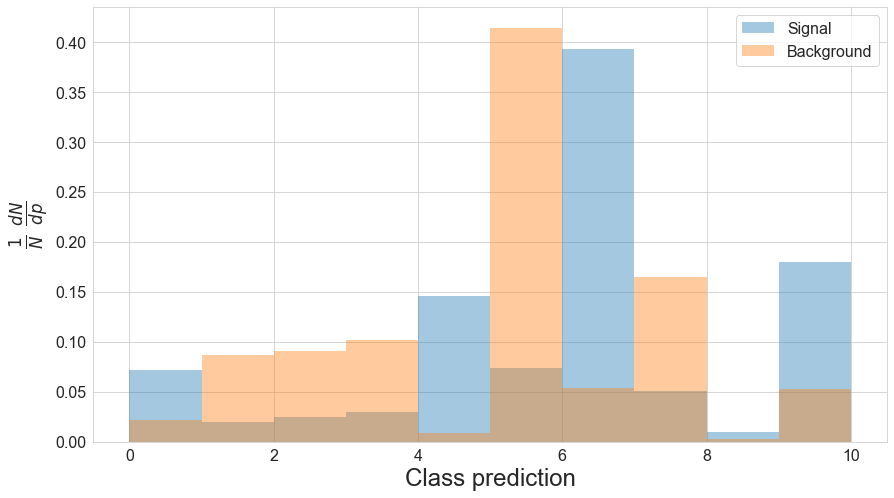

In [16]:
from pytorch_inferno.plotting import plot_preds
import numpy as np
plot_preds(df, bin_edges=np.linspace(0,10,11))

## Parameter estimation

To save time let's test the method on just the easiest and most difficult benchmarks. For readability, I'll hide the code cells (they'll still show up if you open the notebook yourself to run it).

In [17]:
# hide
df['pred_bin'] = df.pred

In [18]:
# hide

from pytorch_inferno.inference import get_shape
f_s,f_b = get_shape(df,targ=1),get_shape(df,targ=0)  # Gets normalised shape for each class
f_s,f_b

(tensor([0.0715, 0.0197, 0.0244, 0.0302, 0.1456, 0.0744, 0.3929, 0.0513, 0.0100,
         0.1801]),
 tensor([0.0220, 0.0869, 0.0907, 0.1021, 0.0090, 0.4148, 0.0535, 0.1650, 0.0027,
         0.0533]))

### Benchmark 0 - No nuisance parameters

In [19]:
# hide

asimov = (50*f_s)+(1000*f_b)
asimov, asimov.sum()

(tensor([ 25.5674,  87.8610,  91.9632, 103.6488,  16.2886, 418.5545,  73.1054,
         167.5467,   3.1862,  62.2782]), tensor(1050.))

In [20]:
# hide
import torch
n = 1050
mu = torch.linspace(20,80,61)
nll = -torch.distributions.Poisson((mu[:,None]*f_s)+(1000*f_b)).log_prob(asimov).sum(1)
nll

tensor([31.6005, 31.4483, 31.3028, 31.1635, 31.0301, 30.9027, 30.7812, 30.6655,
        30.5557, 30.4515, 30.3528, 30.2596, 30.1714, 30.0892, 30.0118, 29.9399,
        29.8725, 29.8107, 29.7539, 29.7018, 29.6547, 29.6121, 29.5741, 29.5412,
        29.5125, 29.4885, 29.4691, 29.4540, 29.4434, 29.4372, 29.4350, 29.4371,
        29.4433, 29.4537, 29.4680, 29.4865, 29.5089, 29.5351, 29.5656, 29.5997,
        29.6375, 29.6794, 29.7249, 29.7738, 29.8265, 29.8828, 29.9424, 30.0061,
        30.0727, 30.1430, 30.2169, 30.2939, 30.3745, 30.4582, 30.5451, 30.6355,
        30.7290, 30.8255, 30.9255, 31.0283, 31.1344])

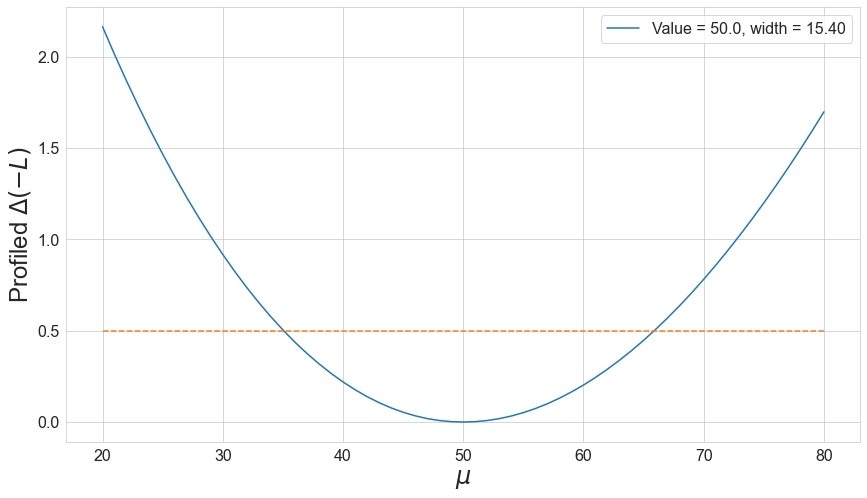

In [21]:
from pytorch_inferno.plotting import plot_likelihood
plot_likelihood(nll-nll.min())

As a reminder, the binary cross-entropy classifier achieved a width of 15.02, and the exact version of INFERNO got 15.86, so the interpolation version does quite well!

### Benchmark 4 - Normalisation uncertainty with auxiliary measurements

In [22]:
# hide
from pytorch_inferno.inference import get_paper_syst_shapes
bkg = test.dataset.x[test.dataset.y.squeeze() == 0]  # Select the background test data
b_shapes = get_paper_syst_shapes(bkg, df, model=model, pred_cb=InfernoPred())

Running: r=-0.2


Running: r=0


Running: r=0.2


Running: l=2.5


Running: l=3


Running: l=3.5


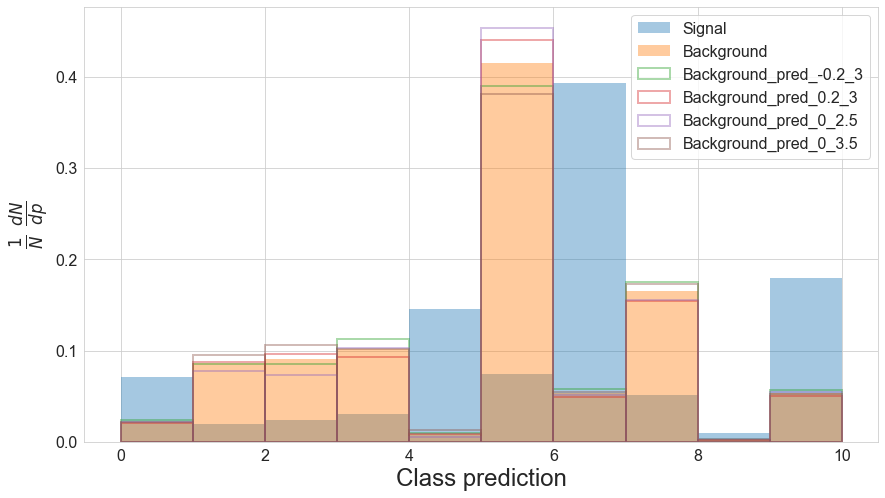

In [26]:
# hide
plot_preds(df, pred_names=['pred', 'pred_-0.2_3', 'pred_0.2_3', 'pred_0_2.5', 'pred_0_3.5'], bin_edges=np.linspace(0,10,11))

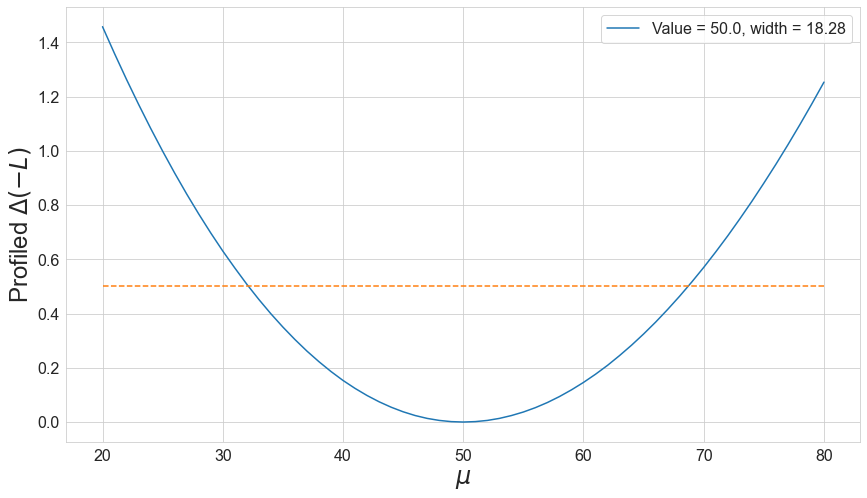

In [25]:
%%capture --no-display
alpha_aux = [torch.distributions.Normal(0,2), torch.distributions.Normal(0,2)]
nll = profiler(alpha_aux=alpha_aux, float_b=True, b_aux=torch.distributions.Normal(1000,100), **b_shapes).cpu().detach()
plot_likelihood(nll-nll.min())

Again, the interpolation method does pretty well: the BCE classifier blew up to a width of 27.74, and the exact version of INFERNO got a much better constraint of 19.08 (slightly high compared to the paper value of 18.79).

## Closing

In this post we've looked at how the INFERNO method can be implemented without requiring analytical knowledge of how the nuisance parameters affect the inputs in the data. Instead we have approximated their affects by interpolating between up/down systematics datasets about the the nominal values. Such datasets are already produced during the course of a typical HEP analysis, and so this approximation improves the potential to be a drop-in replacement for the event-level classifier used in contemporary analyses.

Whilst I've only tested the approximation using the same toy-data problem used by the paper, I have found that it was able to match the performance of the exact version, so I'll be interested to see how well it performs on real-world problems. Certainly, given the difference in performance illustrated by INFERNO (exact or interpolated) and a traditional BCE network, I think the method has a lot to offer in domains where uncertainties play a key role, and I'm looking forward to testing it out.